In [1]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    root_path = '/content/drive/MyDrive/project_work_data/'

    os.chdir(root_path)
    !pwd
else:
    #root_path = r"C:/Users/Michi/Desktop/jupyter_working_dir/Seminar_and_Practical_Work/Data/archiv/"
    root_path = r"C:/Users/meyer/Downloads/Project"
    os.chdir(root_path)
    os.getcwd()

root_path

'C:/Users/meyer/Downloads/Project'

In [1]:
#if IN_COLAB:
#  !pip install lightly

import numpy as np

import torch
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from torch import nn
from lightly.loss import NTXentLoss
from lightly.models.modules import NNCLRPredictionHead, NNCLRProjectionHead, NNMemoryBankModule
from torch import optim
from tqdm.notebook import trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import umap
import umap.plot
import yaml
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

c:\Users\lopez\anaconda3\envs\jku-pr\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#v1_epoch_2 = torch.load('tensors_v1_seed_2.th')
#v2_epoch_2 = torch.load('tensors_v2_seed_2.th')

In [10]:
# LOAD LABELS AND FEATURES OF THE TRAINING AND TEST SET

if IN_COLAB:
    #train_features = torch.load(root_path + "/features_mae_large/mae_l23_cls_train_centercrop.th")
    #train_labels = torch.load(root_path + "/features_mae_large/train-labels.th")
    test_features = torch.load(root_path + "/features_mae_large/mae_l23_cls_test_centercrop.th")
    test_labels = torch.load(root_path + "/features_mae_large/test-labels.th")

else:
    #train_features = torch.load("mae_l23_cls_train_centercrop.th")
    #train_labels = torch.load("train-labels.th")
    test_features = torch.load("mae_l23_cls_test_centercrop.th")
    test_labels = torch.load("test-labels.th")

os.listdir(root_path)

['.idea',
 'checkpoint1.pth',
 'in1k_classid_to_names.yaml',
 'in1k_class_to_classid.yaml',
 'in1k_class_to_classname.yaml',
 'mae_l23_cls_test_centercrop.th',
 'ML_unsupervised.pdf',
 'Project_Work_02.ipynb',
 'test-labels.th']

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, view1_path, view2_path):

        self.data1 = torch.load(view1_path)
        self.data2 = torch.load(view2_path)
        assert self.data1.shape == self.data2.shape, "view1 and view2 must have the same shape"
        self.length = self.data1.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data1[idx], self.data2[idx]

In [4]:
class NNCLR(nn.Module):
    "Prediction head used for NNCLR.“The architecture of the prediction MLP g is 2 fully-connected layers of size [4096,d]. The hidden layer of the prediction MLP is followed by batch-norm and ReLU. The last layer has no batch-norm or activation.”"
    def __init__(self):
        super().__init__()
        self.projection_head = NNCLRProjectionHead(input_dim=1024, hidden_dim=2048, output_dim=256)
        self.prediction_head = NNCLRPredictionHead(input_dim=256, hidden_dim=4096, output_dim=256)

    def forward(self, x):

        z = self.projection_head(x.flatten(start_dim=1))
        p = self.prediction_head(z)
        z = z.detach()
        return z, p


In [7]:
if IN_COLAB:
    samples_train = Dataset(root_path + "features_mae_large/tensors_v1_seed_0.th", root_path + "features_mae_large/tensors_v2_seed_0.th")

    dataloader = torch.utils.data.DataLoader(
        samples_train,
        batch_size = 4096,
        shuffle = True,
        drop_last = True,
        num_workers = 2,
        )
else:
    print("no colab in use => no training")
    #samples_train = Dataset("tensors_v1_seed_0.th", "tensors_v2_seed_0.th")


no colab in use => no training


In [5]:
model = NNCLR()
model.to(device)

memory_bank = NNMemoryBankModule(size=(98304, 256))
memory_bank.to(device)

criterion = NTXentLoss(temperature = 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3, weight_decay=1e-6)


In [6]:
for modules in model.modules():
    print(modules)

NNCLR(
  (projection_head): NNCLRProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=False)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=2048, bias=False)
      (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=256, bias=False)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (prediction_head): NNCLRPredictionHead(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=4096, bias=False)
      (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=4096, out_features=256, bias=True)
    )
  )
)
NNCLRProjectionHead(
  (layers): Sequential(
    (0): Linear(in_features=1024, 

In [10]:
if IN_COLAB:
    print("Starting Training")
    for epoch in range(10):
        total_loss = 0
        for batch in dataloader:
            x0, x1 = batch
            x0 = x0.to(device)
            x1 = x1.to(device)
            z0, p0 = model(x0)
            z1, p1 = model(x1)
            z0 = memory_bank(z0, update=False)
            z1 = memory_bank(z1, update=True)
            loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
            total_loss += loss.detach()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        avg_loss = total_loss / len(dataloader)
        print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
else:
    print("no colab in use => no training")



no colab in use => no training


In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
projection_head.layers.0.weight 	 torch.Size([2048, 1024])
projection_head.layers.1.weight 	 torch.Size([2048])
projection_head.layers.1.bias 	 torch.Size([2048])
projection_head.layers.1.running_mean 	 torch.Size([2048])
projection_head.layers.1.running_var 	 torch.Size([2048])
projection_head.layers.1.num_batches_tracked 	 torch.Size([])
projection_head.layers.3.weight 	 torch.Size([2048, 2048])
projection_head.layers.4.weight 	 torch.Size([2048])
projection_head.layers.4.bias 	 torch.Size([2048])
projection_head.layers.4.running_mean 	 torch.Size([2048])
projection_head.layers.4.running_var 	 torch.Size([2048])
projection_head.layers.4.num_batches_tracked 	 torch.Size([])
projection_head.layers.6.weight 	 torch.Size([256, 2048])
projection_head.layers.7.weight 	 torch.Size([256])
projection_head.layers.7.bias 	 torch.Size([256])
projection_head.layers.7.running_mean 	 torch.Size([256])
projection_head.layers.7.running_var 	 torch.Size([256])
projection_head.layer

In [12]:
torch.save(model.state_dict(), 'checkpoint1.pth')

if IN_COLAB:
    torch.save(model.state_dict(), 'checkpoint1.pth')
else:
    print("no colab in use => no training, no storing")

no colab in use => no training, no storing


In [7]:
state_dict = torch.load('checkpoint1.pth', map_location=device)
print(state_dict.keys())
model.load_state_dict(state_dict)

odict_keys(['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.weight', 'projection_head.layers.7.bias', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.layers.3

<All keys matched successfully>

In [18]:
test_set = DataLoader(test_features, batch_size = 1)
model.eval()

with torch.no_grad():    
    pred = []
    for ii, data in enumerate(test_set):
        input = data
        input = input.to(device)
        prediction = model(input)
        #prediction = torch.argmax(prediction, 1)
        pred.append(prediction[0])

In [25]:
reducer = umap.UMAP()
pred_tensor = torch.cat(pred, axis = 0)
embedding = reducer.fit_transform(pred_tensor)
embedding.shape

(50000, 2)

C:\Users\meyer\AppData\Local\Temp\ipykernel_16236\492781963.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_labels))


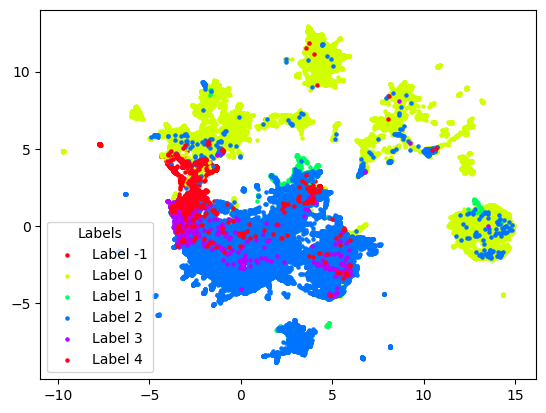

In [65]:
# umap.plot.points(embedding)
#plt.scatter(embedding[:, 0], embedding[:, 1], c = category_labels, alpha=0.5, s = 5)



fig, ax = plt.subplots()
unique_labels = np.unique(category_labels)

colors = plt.cm.get_cmap('hsv', len(unique_labels))


#scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c = colors, alpha=0.5, s = 5)


for i, label in enumerate(unique_labels):
    ax.scatter(embedding[:, 0][category_labels == label], embedding[:, 1][category_labels == label], color=colors(i), label=f'Label {label}', s = 5)

ax.legend(title="Labels")
plt.show()


In [43]:
# Load each YAML file into a dictionary
def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

classid_to_names = load_yaml(os.path.join(root_path, "in1k_classid_to_names.yaml"))
class_to_classid = load_yaml(os.path.join(root_path, "in1k_class_to_classid.yaml"))
class_to_classname = load_yaml(os.path.join(root_path, "in1k_class_to_classname.yaml"))

In [44]:
# dictionary for higher-level categories for UMAP visualization
categories = {
    'animals': 'animal.n.01',
    'vehicles': 'vehicle.n.01',
    'household': 'artifact.n.01',
    'food': 'food.n.01',
    'nature': 'natural_object.n.01'
}

# just a function to help with checking if category exists
def check_synset_exists(synset_name):
    try:
        # Attempt to fetch the synset using the provided name
        syn = wn.synset(synset_name)
        return True, syn.definition()  # Return True and the definition if it exists
    except nltk.corpus.reader.wordnet.WordNetError:
        return False, None  # Return False and None if the synset does not exist

def get_category(labels, categories, class_to_classid):
    category_list = list(categories.keys())
    synset_list = list(categories.values())

    for synset_name in synset_list:
        if not check_synset_exists(synset_name):
            raise ValueError(
                f"The synset '{synset_name}' is not valid."
            )

    # initialize list to store category labels
    category_labels = []
    # loop through all labels
    for label in labels:
        # get the class_id from the class_to_classid dictionary
        class_id = class_to_classid[label.item()]
        synset = wn.synset_from_pos_and_offset('n', int(class_id[1:]))
        searching = True
        while searching:
            # check if the synset is in the synset_list
            if synset.name() in synset_list:
                # if it is, add the category to the category_labels list
                category_labels.append(synset_list.index(synset.name()))
                searching = False
            else:
                try:
                    # if it is not, move up the hypernym tree
                    synset = synset.hypernyms()[0]
                except:
                    # if there are no more hypernyms, add -1 to the category_labels list
                    category_labels.append(-1)
                    searching = False

    return category_list, category_labels


In [45]:
category_names, category_labels = get_category(test_labels, categories, class_to_classid)

In [46]:
torch.Tensor(category_labels).unique(return_counts=True)

(tensor([-1.,  0.,  1.,  2.,  3.,  4.]),
 tensor([ 2050, 19900,  1200, 24900,  1100,   850]))